# 使用信息论评估特征

特征和结果之间的互信息 (MI) 是两个变量之间相互依赖性的度量。它将相关性的概念扩展到非线性关系。更具体地说，它量化通过另一个随机变量获得的关于一个随机变量的信息。

MI 的概念与随机变量熵的基本概念密切相关。熵量化随机变量中包含的信息量。形式上，两个随机变量 X 和 Y 的互信息 I(X, Y) 定义如下：

sklearn 函数实现了 feature_selection.mutual_info_regression，计算所有特征之间的互信息和连续结果，以选择最有可能包含预测信息的特征。还有一个分类版本（更多详细信息请参阅文档）。

该笔记本包含对我们在第 4 章 Alpha 因子研究中创建的财务数据的应用。

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## 获取数据

我们使用 [第 4 章](../../04_alpha_factor_research/00_data/feature_engineering.ipynb) 中生成的数据。


In [4]:
with pd.HDFStore('../data/assets.h5') as store:
    data = store['engineered_features']

## 创建虚拟变量

In [5]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              358914 non-null  float64
 1   return_2m              358914 non-null  float64
 2   return_3m              358914 non-null  float64
 3   return_6m              358914 non-null  float64
 4   return_9m              358914 non-null  float64
 5   return_12m             358914 non-null  float64
 6   Mkt-RF                 358914 non-null  float64
 7   SMB                    358914 non-null  float64
 8   HML                    358914 non-null  float64
 9   RMW                    358914 non-null  float64
 10  CMA                    358914 non-null  float64
 11  momentum_2             358914 non-null  float64
 12  momentum_3             358914 non-null  float64
 13  momentum_6     

## 互信息

### 原始数据

In [6]:
target_labels = [f'target_{i}m' for i in [1,2,3,6,12]]
targets = data.dropna().loc[:, target_labels]

features = data.dropna().drop(target_labels, axis=1)
features.sector = pd.factorize(features.sector)[0]

cat_cols = ['year', 'month', 'msize', 'age', 'sector']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [7]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [8]:
mutual_info.sum()

target_1m     0.034550
target_2m     0.057801
target_3m     0.091099
target_6m     0.132955
target_12m    0.199361
dtype: float64

### 归一化 MI 热图

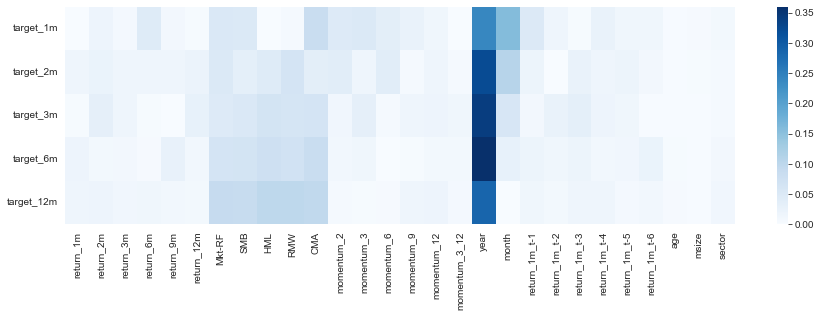

In [9]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

### 虚拟数据

In [10]:
target_labels = [f'target_{i}m' for i in [1, 2, 3, 6, 12]]
dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [11]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [12]:
mutual_info_dummies.sum()

target_1m     0.035691
target_2m     0.059732
target_3m     0.093805
target_6m     0.136928
target_12m    0.204094
dtype: float64

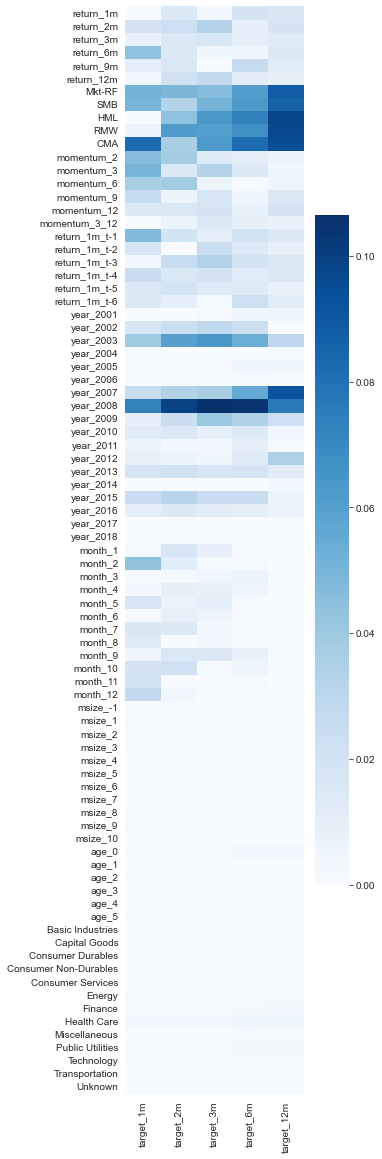

In [13]:
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');